# Practical 06 - Regression


As usual, you should save a copy of this notebook in Google drive (or on your own system if not using Colaboratory)

In this session we will:
- load and explore a data set from astronomy
- Perform feature selection, feature engineering, and data scaling
- Train three models on our data:
  - A KNN regressor
  - A linear regression model
  - A descision tree regressor
- Compare and contrast the results from our models.

In [ ]:
# data reading and manipulation libraries
import numpy as np
import pandas as pd
# plotting libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning tools
import sklearn
from sklearn import (metrics, preprocessing, linear_model, model_selection)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
print(f"Numpy:        {np.__version__}")
print(f"Pandas:       {pd.__version__}")
print(f"Matplotlib:   {matplotlib.__version__}")
print(f"Seaborn:      {sns.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")

Numpy:        1.23.5
Pandas:       1.5.3
Matplotlib:   3.7.1
Seaborn:      0.12.2
Scikit-learn: 1.2.2


## Data preparation

We will be working with a data set that comes from astronomy.
The data have been downloaded from an archive filtered to be relevant for this practical.
We can pull the data directly from my GitHub.

In [ ]:
galaxy_df = pd.read_csv("https://raw.githubusercontent.com/PaulHancock/2023-ASA-ML-DeepDive/main/SDSS_10k_Galaxy.csv")

In [ ]:
galaxy_df.columns

Index(['objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'rerun', 'camcol',
       'field', 'specobjid', 'class', 'redshift', 'plate', 'mjd', 'fiberid',
       'SpType', 'BV', 'TEff', 'FeH'],
      dtype='object')

Above we can see the following columns:
- objid: the object identifier, an integer
- ra, dec: the location of the object on the sky (ra/dec = lat/long for the sky)
- u,g,r,i,z: photometric observations. How bright an object is in each part of the spectrum, measured in magnitudes, which is a logarithmic scale.
- run, rerun, camcol, field, specobjid, plate, fiberid: meta-data associated with the observation. Not specific to the object but descirbes the setup of the instrument during the observaiton.
- redshift: the redshift of the object being observed. This is a measure of distance for astronomers.
- mjd: the date of the observaiton
-SpType, BV, TEff, FeH: properties of the object which are all null because these are only valid for stars and our data has been filtered to include only galaxies.

In [ ]:
galaxy_df.describe()

,objid,ra,dec,u,g,r,i,z,run,rerun,...,field,specobjid,redshift,plate,mjd,fiberid,SpType,BV,TEff,FeH
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.0,...,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.00000,0.0,10000.0,10000.0,10000.0
mean,1.237665e+18,163.366791,20.965777,22.397440,20.805410,19.529200,18.802429,18.388960,4447.77040,301.0,...,183.284700,5.865334e+18,0.417744,5209.366200,55489.251200,396.79450,NaN,0.0,0.0,0.0
std,7.985401e+12,74.752272,16.115423,2.329123,2.270056,2.010137,1.798883,1.743834,1859.25356,0.0,...,122.821667,3.852823e+18,0.284065,3421.976387,2038.451799,258.60008,NaN,0.0,0.0,0.0
min,1.237646e+18,0.202136,-9.409396,15.028880,13.857590,12.946620,12.395470,12.149890,94.00000,301.0,...,11.000000,2.995158e+17,-0.007743,266.000000,51630.000000,1.00000,NaN,0.0,0.0,0.0
25%,1.237658e+18,132.405403,6.082047,20.340373,18.557555,17.638993,17.214298,16.922108,2964.00000,301.0,...,100.000000,2.374583e+18,0.132859,2109.000000,53795.000000,166.75000,NaN,0.0,0.0,0.0
50%,1.237665e+18,153.811026,17.818288,22.726710,21.487835,20.032355,19.135210,18.680125,4508.00000,301.0,...,163.000000,5.837843e+18,0.438956,5185.000000,55978.000000,381.00000,NaN,0.0,0.0,0.0
75%,1.237668e+18,218.183065,32.970094,24.113957,22.528742,21.220797,20.169052,19.585217,5314.00000,301.0,...,238.000000,8.596317e+18,0.616611,7635.000000,56979.000000,565.00000,NaN,0.0,0.0,0.0
max,1.237681e+18,359.678397,64.764792,28.017250,27.006480,30.697160,27.923300,26.649440,8162.00000,301.0,...,825.000000,1.412463e+19,1.972819,12545.000000,58932.000000,1000.00000,NaN,0.0,0.0,0.0


### Feature selection

We will remove all the "non-physical" properties from our dataset, and our goal is to use the (u,g,r,i,z) photometric magnitudes to predict the redshift of the galaxies.

In astronomy, the redshift is measured by taking a spectrum of an object, and this typically takes a long time to measure using large and very expensive telescopes. The photometric magnitude of an object can be measured relatively quickly, so being able to predict redshifts from photometry means that we could use a lot less time, or by using smaller and less expensive instruments.

In [ ]:
galaxy_df = galaxy_df[ ['u','g','r','i','z','redshift']]

### Data scaling

Our data are calibrated to a physically meaningful scale, however the different magnitudes don't share the same distributions.

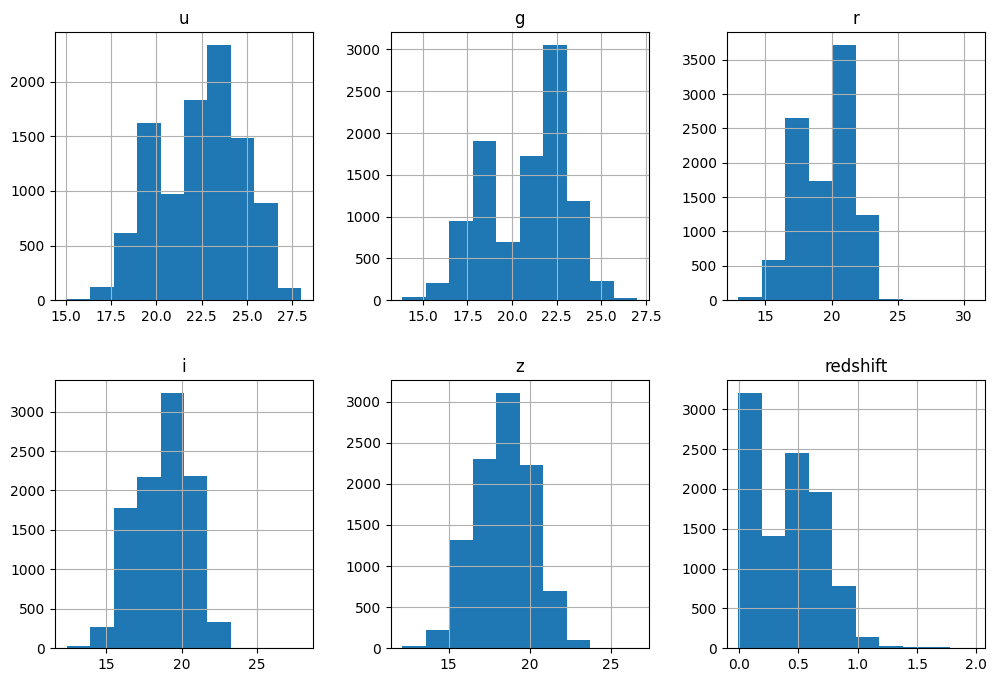

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(12, 8))
galaxy_df.hist(grid=True, ax=ax)
plt.show()

In order to eliminate issues with scaling we will transform all our features using a min/max scaler.
Some of the features look like they may have a normal or power-law distribution, so min/max might not be the best solution, but this is what we'll go with for now.
You can come back and try different scalers at a later time.

The preprocessing classes have a similar interface to the ML models:
- `.fit` to fit the transformer to your data
- `.transform` to return the transformed data
- `.fit_transform` to do both at once

In [ ]:
# create a minmax scaler
minmax = preprocessing.MinMaxScaler()
# "fit" the scaler -> determine the min/max for each column
minmax.fit(galaxy_df)

#make a copy of the data frame we are about to scale
scaled_df = galaxy_df.copy()
# Transform the data and save it back to our dataframe
scaled_df[:] = minmax.transform(scaled_df)
#        ^ this slicing hack causes the values of the pandas dataframe to
# be overwritten with the values from a numpy array (from the tranform)

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Look at our scaled data to check the effects of our code.

You should see all columns have a $min = 0$ and $max = 1.0$

In [ ]:
scaled_df.describe()

,u,g,r,i,z,redshift
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.567320,0.528396,0.370838,0.412611,0.430294,0.214831
std,0.179324,0.172642,0.113244,0.115849,0.120268,0.143426
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.408942,0.357442,0.264351,0.310335,0.329129,0.070991
50%,0.592671,0.580296,0.399184,0.434043,0.450375,0.225541
75%,0.699478,0.659459,0.466137,0.500623,0.512797,0.315241
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


A more compact way to visualise the spread of data within our range $[0,1]$ is to use a box and whisker plot.

Seaborn gives us a fairly nice way to do this, we just have to make sure that we fiddle the axis labels so they don't overlap.

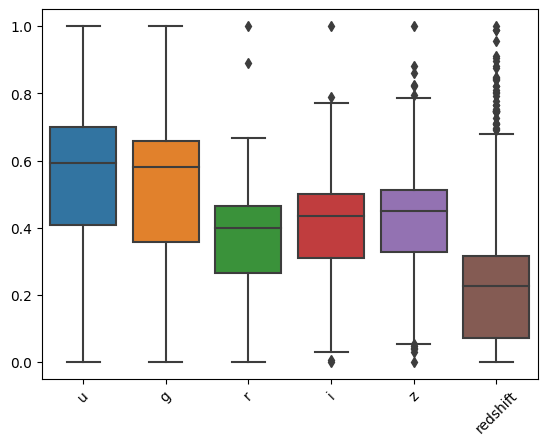

In [ ]:
ax = sns.boxplot(scaled_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

For a full view of the correlation of all parameters we can use the pandas `.corr()` method to compute the correlation and then the seaborn `.heatmap()` method to display it.

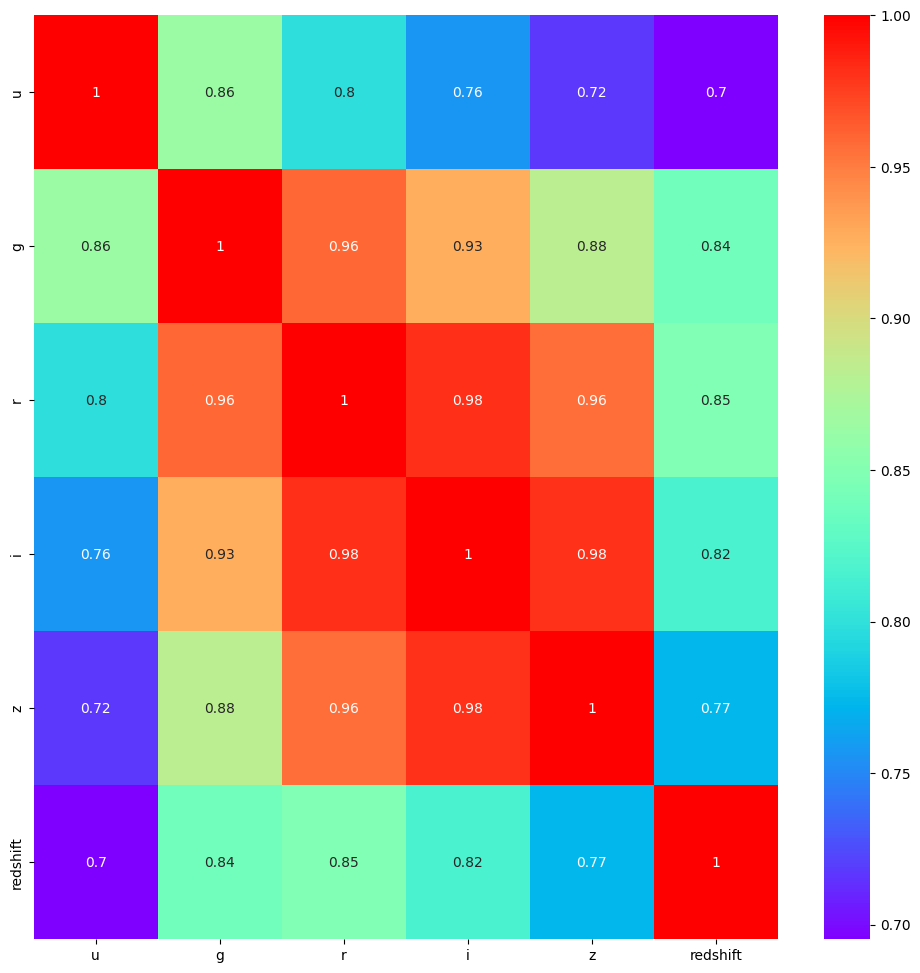

In [ ]:
# Compute the correlation between each of the numeric parameters as well as the
# target attribute
cor = scaled_df.corr()

# use seaborn to do the plot
fig, ax = plt.subplots(1,1, figsize=(12,12))
sns.heatmap(cor, annot=True, cmap=plt.cm.rainbow, ax=ax)
plt.show()

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Is correlation the best way to judge the utility of a feature?

What assumptions are we making here?

How could we make different assumptions?

### Feature engineering

A commonly used feature that astronomers use to classify galaxies into different types are the spectral shapes (or colours) of the galaxy.
These colours are ratios of brightness levels, which correspond to linear combinations of magnitudes.

Let us add some additional features which are the pariwise differences between neighbouring bands.

Note that we need to compute the difference in the raw data first so that we are working with physically meaningful features. We then scale this with our minmax scaler.

In [ ]:
X = scaled_df.drop(columns='redshift')
# Create colours as our new features
X['u-g'] = galaxy_df['u'] - galaxy_df['g']
X['g-r'] = galaxy_df['g'] - galaxy_df['r']
X['r-i'] = galaxy_df['r'] - galaxy_df['i']
X['i-z'] = galaxy_df['i'] - galaxy_df['z']
# Once computed we can scale the new features so that they also have a range of [0,1]
X[ ['u-g','g-r','r-i','i-z'] ] = minmax.fit_transform(X[ ['u-g','g-r','r-i','i-z'] ])

y = galaxy_df['redshift'] # we want unscaled reshifts to be predicted

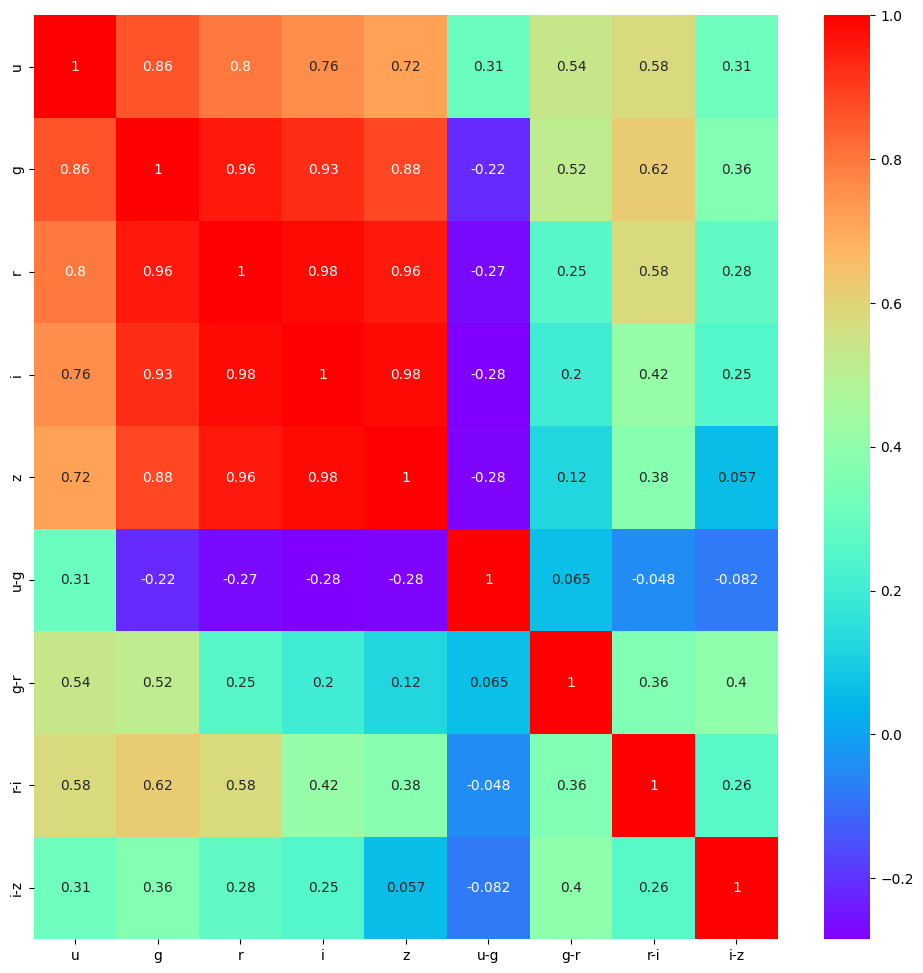

In [ ]:
# Compute the correlation between each of the numeric parameters as well as the
# target attribute
cor = X.corr()

# use seaborn to do the plot
fig, ax = plt.subplots(1,1, figsize=(12,12))
sns.heatmap(cor, annot=True, cmap=plt.cm.rainbow, ax=ax)
plt.show()

Looking at the correlation map above we can see examples of:
- attribtes which have a correlation of ~1,
- attributes which are highly correlated with the redshift,
- attributes which have very low correlation with the redshift.

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

In each of the above cases, how does this inform our feature selection?

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Create a test/train split from our `X` data.


In [ ]:
# Split our data into a test/train set
# We use the training set to build our model
# We use the test set to measure the performance of our model
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y,
                                                                    test_size=0.25, # use a test size of 25%
                                                                    random_state=4) # this random state ensures that we get the same subset each time we call this cell

## KNN regressor

We can do our gridsearch as before however we can no longer use 'accuracy' as a metrics, since we don't have categorical data.

Instead we need to use a different scoring metric.

For now let's use the $R^2$ metric since it's easy do understand.

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Perform a gridsearch with cross validation using the `r2` metric for scoring.



In [ ]:
# Create a dictionary of all the parameters we'll be iterating over
parameters = {'weights': ('uniform','distance'), # this should be the different weighting schemes
              'n_neighbors':[1,3,5,7,13,17,21,43]} # this should be a list of the nearest neigbhours
# make a classifier object
estimator = KNeighborsRegressor()
# create a GridSearchCV object to do the training with cross validation
gscv = model_selection.GridSearchCV(estimator=estimator,
                                    param_grid=parameters,
                                    scoring='r2')
# now train our model
knn = gscv.fit(X_train, y_train)
knn_y_pred = knn.predict(X_test)
print(knn.best_params_, knn.best_score_)

{'n_neighbors': 21, 'weights': 'distance'} 0.778476153805121


We have used cross validation which means that we can see the average and variance of the test score across the different validation splits. We can also view this for each of the parameter combinations.

In [ ]:
print("n_neighbors |  weights    |     R2 +/- std")
for i in range(len(knn.cv_results_['params'])):
  print(f"{knn.cv_results_['params'][i]['n_neighbors']:4d}   ", end='')
  print(f"{knn.cv_results_['params'][i]['weights']:>15s}     ", end='')
  print(f"{knn.cv_results_['mean_test_score'][i]: 5.3f}  +/- ", end='')
  print(f"{knn.cv_results_['std_test_score'][i]:5.3f}")

n_neighbors |  weights    |     R2 +/- std
   1           uniform      0.613  +/- 0.071
   1          distance      0.613  +/- 0.071
   3           uniform      0.739  +/- 0.036
   3          distance      0.738  +/- 0.035
   5           uniform      0.757  +/- 0.032
   5          distance      0.758  +/- 0.032
   7           uniform      0.762  +/- 0.034
   7          distance      0.764  +/- 0.034
  13           uniform      0.775  +/- 0.031
  13          distance      0.776  +/- 0.031
  17           uniform      0.776  +/- 0.030
  17          distance      0.778  +/- 0.030
  21           uniform      0.777  +/- 0.030
  21          distance      0.778  +/- 0.030
  43           uniform      0.775  +/- 0.029
  43          distance      0.777  +/- 0.029


Is there a significant difference between the best and worst performing model in the above table?

How do you interpret your answer to the above?

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Retrain our KNN model using the best parameters and recompute the $R^2$ metric. Compare the new score to our expecations from above.

In [ ]:
# use the best n_neighbors and weights
knn = KNeighborsRegressor(n_neighbors=13, weights='distance')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
r2 = metrics.r2_score(y_test, y_pred)
print(f'R^2 = {r2}')

R^2 = 0.7992056316566664


We are going to be running more than one model so let us save a summary of the results into a dataframe.

In [ ]:
deltas = pd.DataFrame()
deltas['y-knn_y'] = y_test-knn_y_pred
deltas.describe()

,y-knn_y
count,2500.000000
mean,0.004464
std,0.129876
min,-0.798708
25%,-0.030578
50%,0.000762
75%,0.037889
max,1.359236


The above data frame doesn't give us a good feeling of how well the model predicts the data, so let's make a plot to visualise it.

Text(0.5, 1.0, 'KNN redshift estimation')

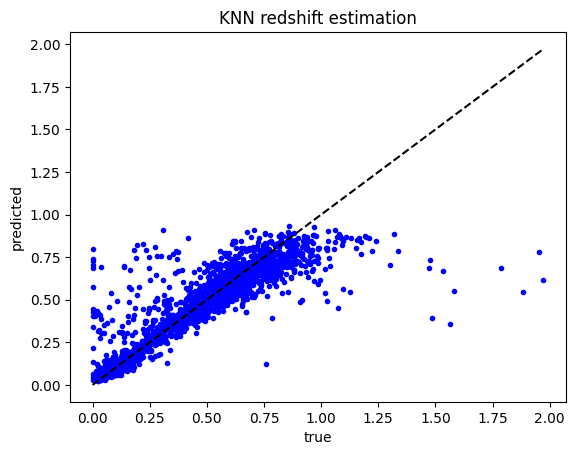

In [ ]:
mx = max(y_test.max(), knn_y_pred.max())
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(y_test,knn_y_pred, 'b.')
ax.plot([0,mx], [0, mx], 'k--')
ax.set_xlabel("true")
ax.set_ylabel("predicted")
ax.set_title("KNN redshift estimation")

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)
In the above plot, you should see that your ML model has done a fairly good job of estimating the redshift for the vast majority of galaxies.
The variance is less than 0.1.
However, the predictor doesn't seem to want to predict redshifts higher than about 1.0, even though there are some $z~1$ galaxies in our sample.

Why might this be the case?

## Linear regression

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Fit a linear regression model to our data and predict some redshifts

In [ ]:
# no need for a grid search as there are no hyper-parameters to tune
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
lr_y_pred = lr.predict(X_test)

For a little fun, let's have a look at the euqation of best fit that was generated by our model.

In [ ]:
print("redshift = ",end='')
for feature, coef in zip(X.columns, lr.coef_):
  print(f"{coef:+5.3f}*{feature} ", end='')
print(f"{lr.intercept_:+5.3f}")

redshift = +2074769791787.534*u -3341761242618.708*g +1038686560384.258*r +103246490748.916*i +424000224611.873*z -2276629173895.466*u-g +2072480674004.504*g-r +751851118039.618*r-i +342441396479.709*i-z -887414007875.436


![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

What does it mean for a feature to have a high or low weight in the above equation?

If we were using un-scaled data would you have a different answer?

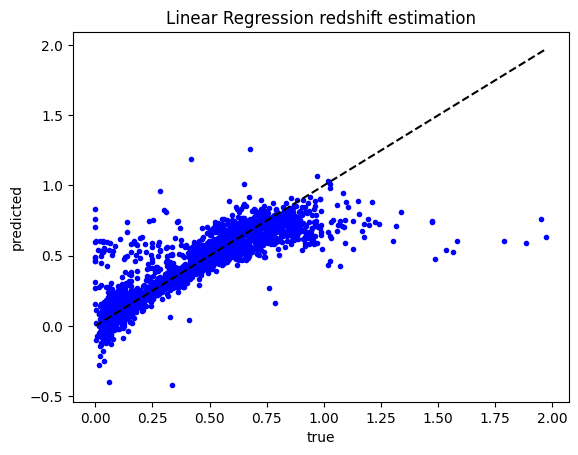

In [ ]:
mx = max(y_test.max(), lr_y_pred.max())
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(y_test,lr_y_pred, 'b.')
ax.plot([0,mx], [0, mx], 'k--')
ax.set_xlabel("true")
ax.set_ylabel("predicted")
ax.set_title("Linear Regression redshift estimation")
plt.show()

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

What are some features of the above plot that are different from the KNN version of the plot?

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Add a new column to our `deltas` data frame for the linear regression results and compare them to the knn results.

In [ ]:
deltas['y-lr_y'] = y_test-lr_y_pred
deltas.describe()

,y-knn_y,y-lr_y
count,2500.000000,2500.000000
mean,0.004464,0.001898
std,0.129876,0.146119
min,-0.798708,-0.832520
25%,-0.030578,-0.055014
50%,0.000762,-0.004445
75%,0.037889,0.052152
max,1.359236,1.341593


## Regression trees

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Train a `DescisionTreeRegressor` with a range of `max_depth` and `min_samples_split`, using the `r2` scoring metric.

In [ ]:
# Create a dictionary of all the parameters we'll be iterating over
parameters = {'max_depth': [2, 3, 5, 7, 9, 11], #
              'min_samples_split':[50,150,500,1000]} #
# make a classifier object
estimator = DecisionTreeRegressor()
# create a GridSearchCV object to do the training with cross validation
gscv = model_selection.GridSearchCV(estimator=estimator,
                                    param_grid=parameters,
                                    scoring='r2')
# now train our model
dtr = gscv.fit(X_train, y_train)
dtr_y_pred = dtr.predict(X_test)
print(dtr.best_params_, dtr.best_score_)

{'max_depth': 7, 'min_samples_split': 1000} 0.7581795674682226


![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Use the best parameters from above to retrain on all the training data.

In [ ]:
best_dtr = DecisionTreeRegressor(max_depth=7,
                                 min_samples_split=1000)
best_dtr.fit(X_train, y_train)
dtr_y_pred = best_dtr.predict(X_test)

As with our

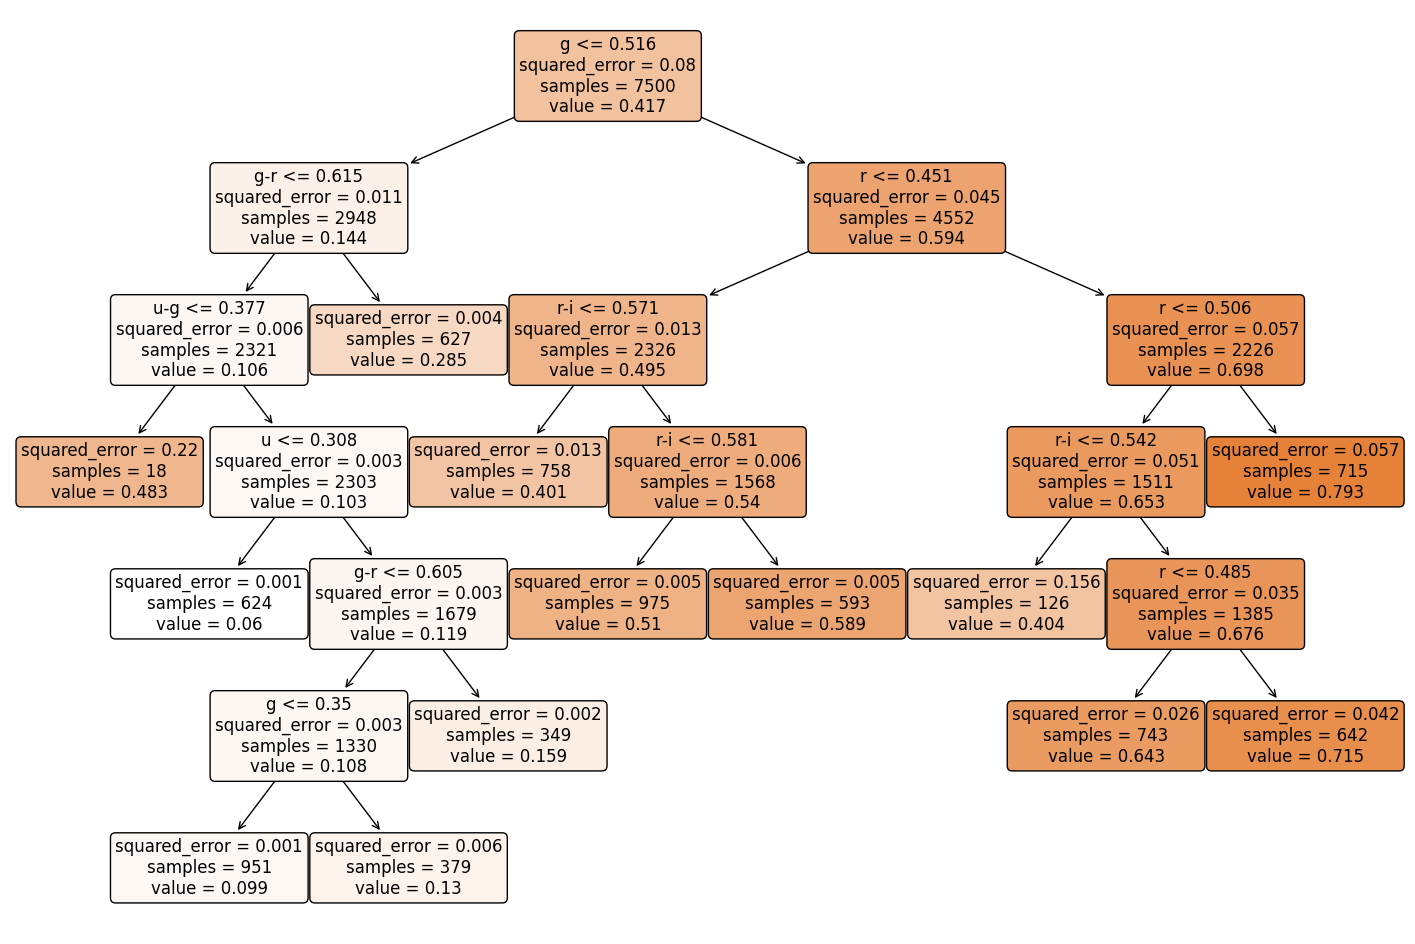

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(18,12))
sklearn.tree.plot_tree(best_dtr,
               filled=True,
               feature_names = X.columns,
               rounded=True,
               ax=ax,
               fontsize=12, )
plt.show()

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Inspect the tree above and determine how many unique values of redshift it can produce.

Additionally, determine if there are any features that are not used, and review these features in the correlation plot we made earlier. Do you see any agreement?

In [ ]:
deltas['y-dtr_y'] = y_test-dtr_y_pred
deltas.describe()

,y-knn_y,y-lr_y,y-dtr_y
count,2500.000000,2500.000000,2500.000000
mean,0.004464,0.001898,0.001616
std,0.129876,0.146119,0.137404
min,-0.798708,-0.832520,-0.793434
25%,-0.030578,-0.055014,-0.039885
50%,0.000762,-0.004445,-0.003543
75%,0.037889,0.052152,0.038936
max,1.359236,1.341593,1.179385


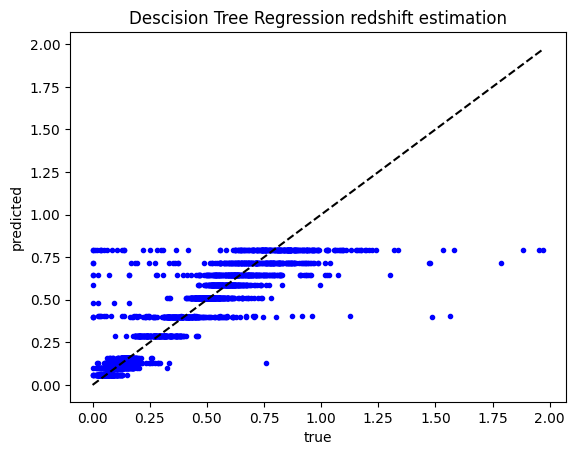

In [ ]:
mx = max(y_test.max(), dtr_y_pred.max())
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(y_test,dtr_y_pred, 'b.')
ax.plot([0,mx], [0, mx], 'k--')
ax.set_xlabel("true")
ax.set_ylabel("predicted")
ax.set_title("Descision Tree Regression redshift estimation")
plt.show()

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Based on the graph, the $R^2$ metric, and the above table, which of the three models is performing the best?